Downloading DEM data directly (mostly SRTM).
Partially following the [Medium article](https://medium.com/towards-data-science/accessing-and-visualizing-digital-elevation-models-with-python-f4fd7f595d46)
Sources
- USGS Earth Explorer: https://earthexplorer.usgs.gov/
- Copernicus Land Monitoring Service: https://www.eea.europa.eu/data-and-maps/data/copernicus-land-monitoring-service-eu-dem



In [6]:
import os
import elevation #to download the DEM data
import rasterio as rio
import rioxarray as riox
from rasterio.plot import show
import geopandas as gpd
import folium as fl

/home/cperalta/anaconda3/envs/py310/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [35]:
#data from https://data.humdata.org/dataset/cod-ab-arm
data_path="data/arm_admbnda_adm1_2019.shp"
#df_armenia_shp = gpd.read_file('arm_adm_2029_shp/arm_admbnda_adm1_2019.shp')

df_armenia_shp = gpd.read_file(data_path)
    
m = fl.Map(zoom_start=100, tiles="OpenStreetMap")
# the line above plots the whole world. To use a more precise zoom use https://stackoverflow.com/questions/73405381/folium-get-location-and-zoom-level


for _, r in df_armenia_shp.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = fl.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    fl.Popup(r["ADM1_EN"]).add_to(geo_j)
    geo_j.add_to(m)
m    

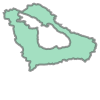

In [9]:
# To download the DEM, let us choose one of the provinces Gegharkunik.

from shapely.ops import unary_union

selected_province = 'Gegharkunik'
gdf_selected_province = df_armenia_shp[df_armenia_shp['ADM1_EN']==selected_province]
combined_polygon = unary_union(gdf_selected_province['geometry'].values)
combined_polygon

make: Entering directory '/home/cperalta/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/cperalta/.cache/elevation/SRTM1'
make: Entering directory '/home/cperalta/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/cperalta/.cache/elevation/SRTM1'
make: Entering directory '/home/cperalta/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.118e35e0b5784a61a4b956e74b2bdfd0.vrt
make: Leaving directory '/home/cperalta/.cache/elevation/SRTM1'
make: Entering directory '/home/cperalta/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 44.77962061300008 40.743155182000066 45.98213257400005 39.87080355100005 SRTM1.118e35e0b5784a61a4b956e74b2bdfd0.vrt /media/cperalta/USB128_extra/data/scripts/python/learning/learning/GIS/data/image_original.tif
rm -f SRTM1.118e35e0b5784a61a4b956e74b2bdfd0.vrt
make: Leaving directory '/home/cperalta/.cache/elevation/SRTM1'


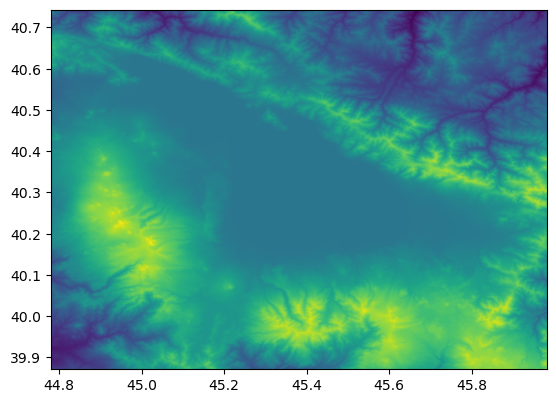

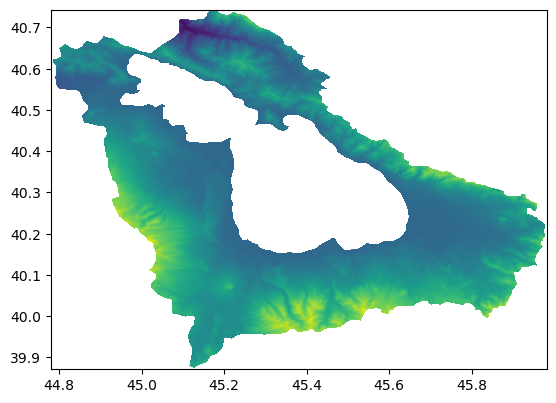

<AxesSubplot:>

In [12]:
dem_path = '/data/image_original.tif'
output = os.getcwd() + dem_path

#Extract dem based on bounds extracted from the ADM boundary polygon

bounds_combined = combined_polygon.bounds
west_c, south_c, east_c, north_c = bounds_combined
elevation.clip(bounds=bounds_combined, output=output, product='SRTM1')
dem = rio.open(output)
show(dem)

# The bounds does not extract in the same shape as the polygon but using the bounds
# The following script clips based on the polygon

raster = riox.open_rasterio(output)
# Shapely Polygon  to clip raster
geom = combined_polygon

# Use shapely polygon in clip method of rioxarray object to clip raster
clipped_raster = raster.rio.clip([geom])
 
dem_path1 = '/data/image_clipped.tif'
output1 = os.getcwd() + dem_path1

# Save clipped raster
clipped_raster.rio.to_raster(output1)

dem = rio.open(output1)
show(dem)

Visualizing DEM terrain attributes with matplotlib and RichDEM


In [24]:
type(dem)

rasterio.io.DatasetReader

In [25]:
#nice intro into how to open the dem into n numpy array
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python/
with rio.open(output1) as dem_src:
    dem_array = dem_src.read(1, masked=True)

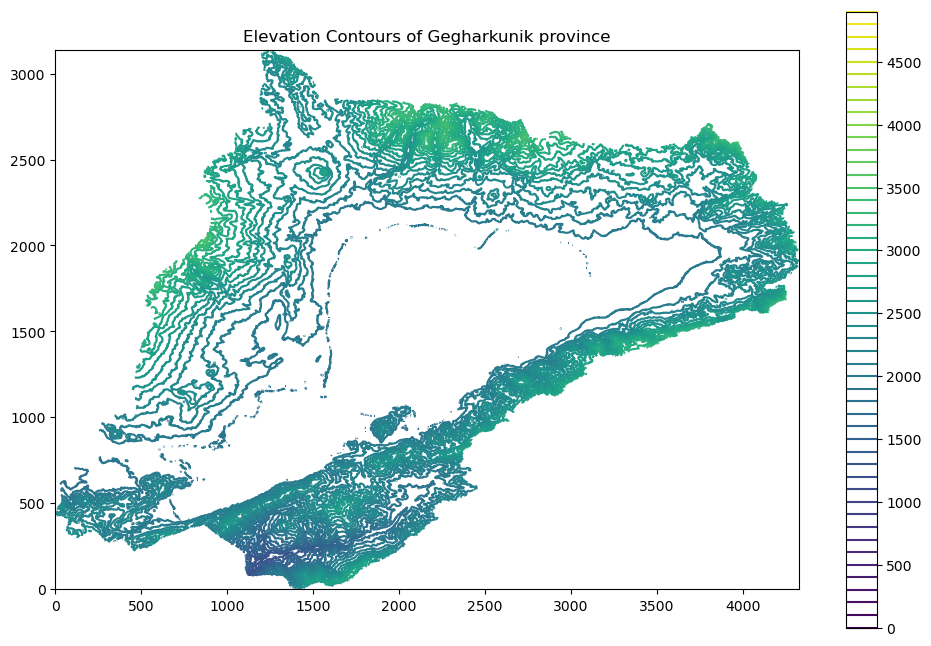

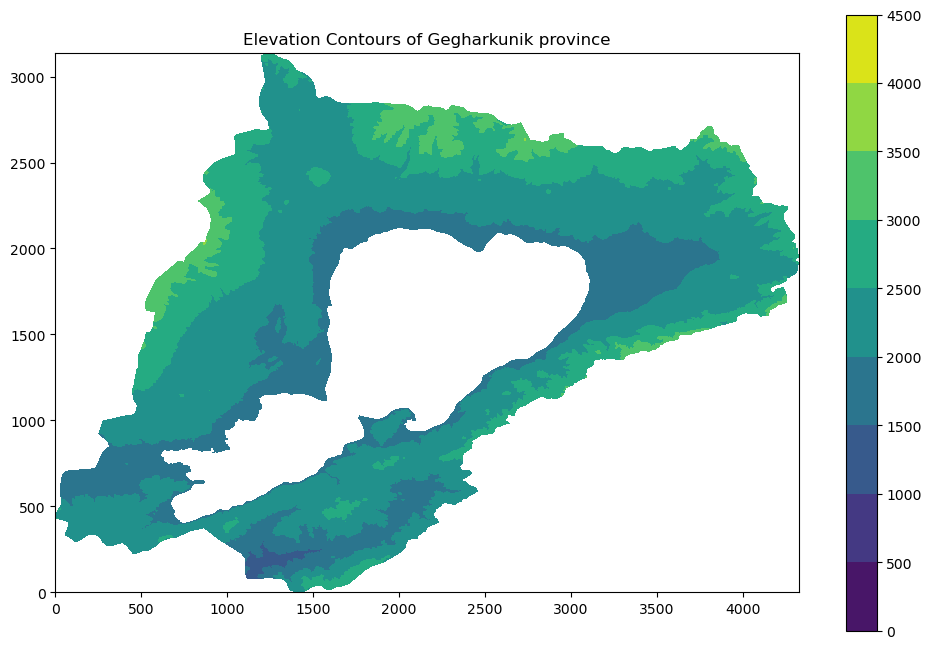

In [27]:
import matplotlib.pyplot as plt

# Plot out data with Matplotlib's 'contour' 
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contour(dem_array, cmap = "viridis", 
            levels = list(range(0, 5000, 100)))
plt.title("Elevation Contours of "+selected_province+" province")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# For filled Contour plots, use contourf 
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(dem_array, cmap = "viridis", 
            levels = list(range(0, 5000, 500)))
plt.title("Elevation Contours of "+selected_province+" province")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

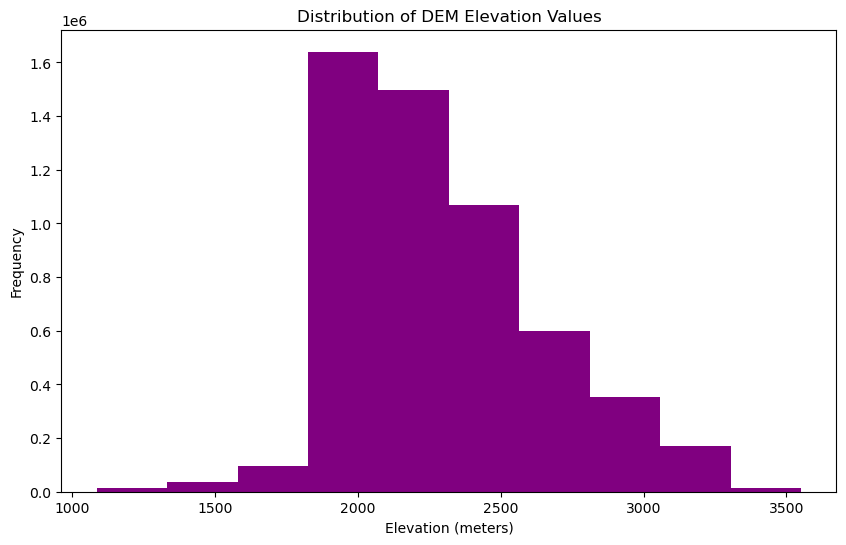

In [28]:
#histogram
dem_im = riox.open_rasterio(output1,masked=True)

f, ax = plt.subplots(figsize=(10, 6))
dem_im.plot.hist(ax=ax,
       color="purple")
ax.set(title="Distribution of DEM Elevation Values",
       xlabel='Elevation (meters)',
       ylabel='Frequency')
plt.show()

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.341153======================= ] (99% - 0.0s - 1 threads)


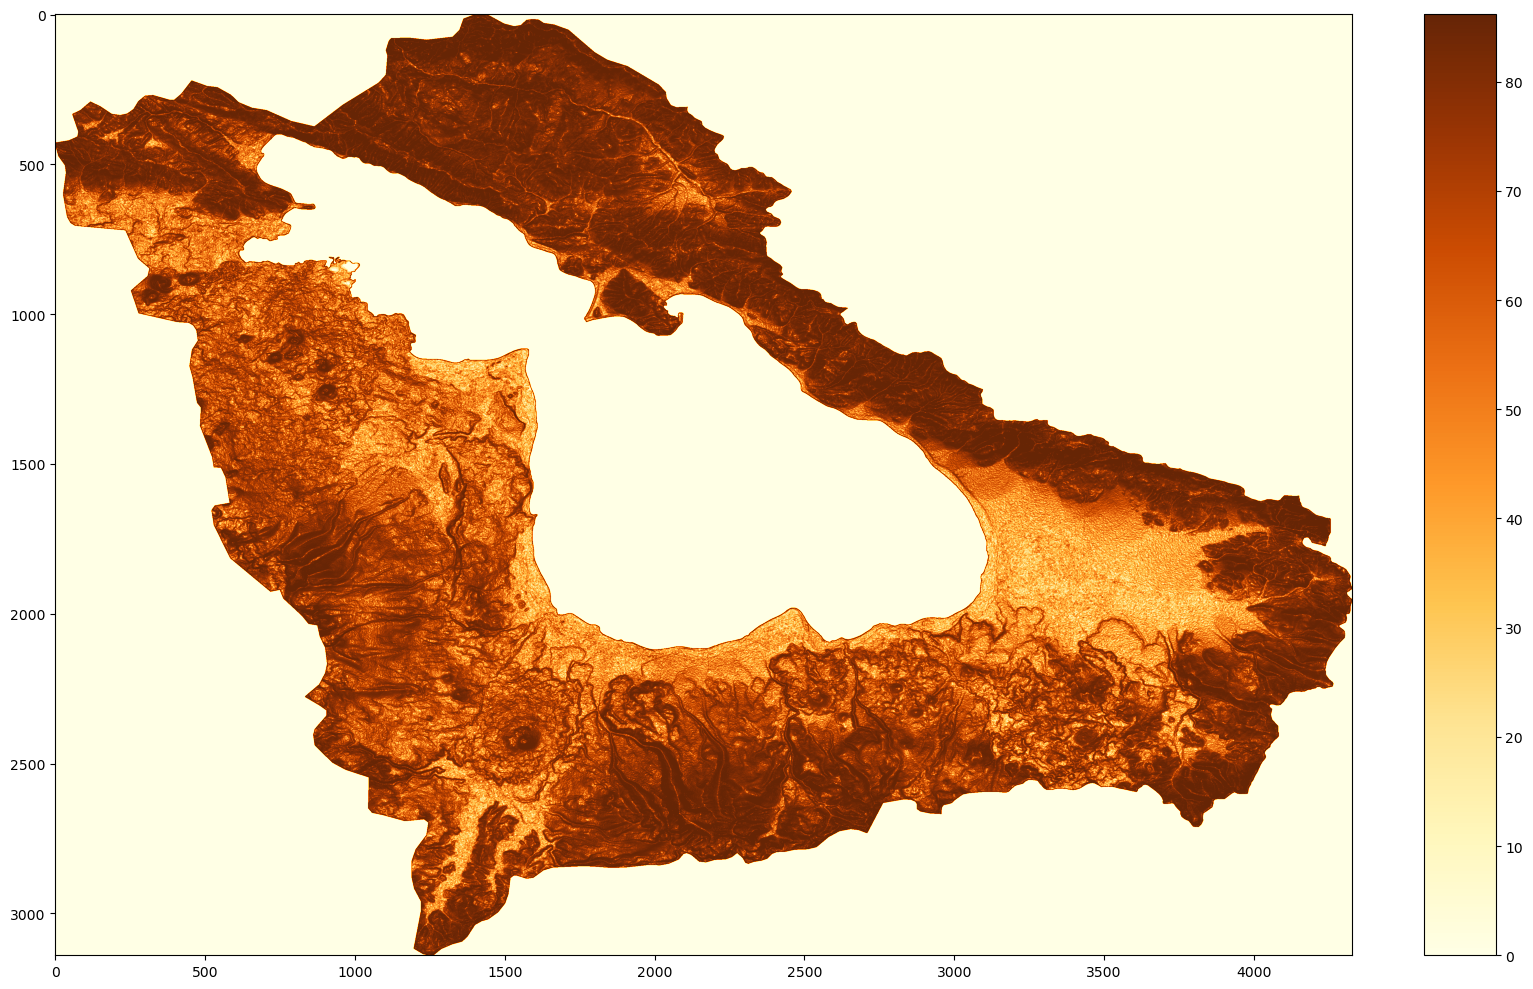

In [31]:
# plot the slopes
import richdem as rd
beau  = rd.rdarray(dem_array, no_data=-9999)

dem_slope = rd.TerrainAttribute(beau, attrib='slope_degrees')
rd.rdShow(dem_slope, axes=True, cmap='YlOrBr', figsize=(16, 10));

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.176421======================= ] (99% - 0.0s - 1 threads)


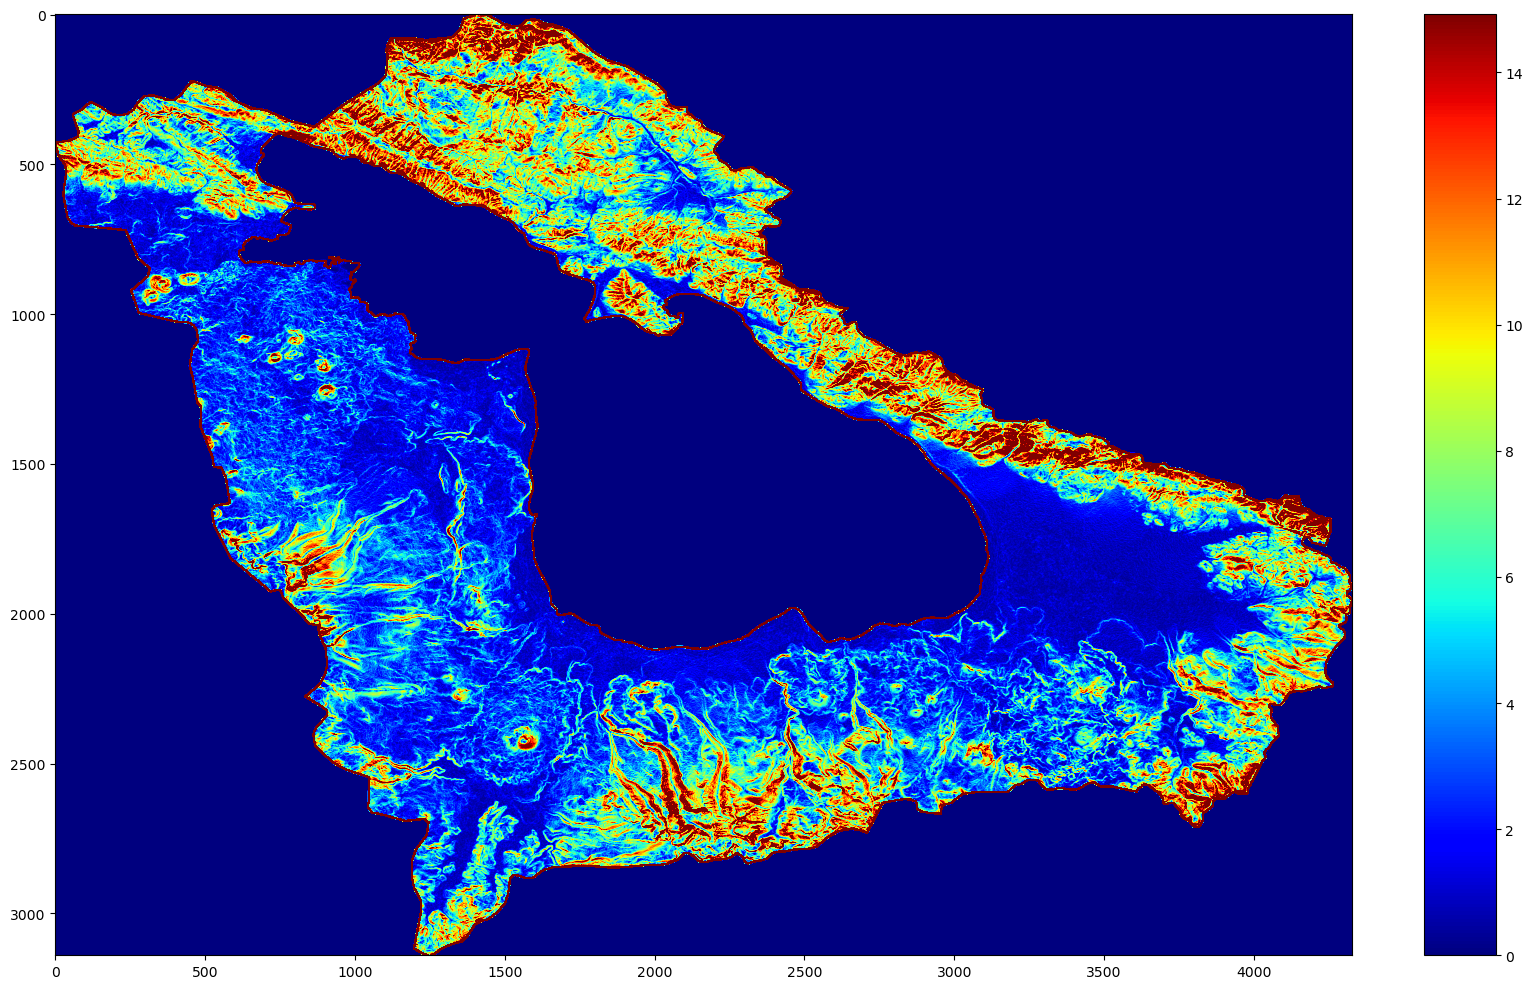

{'vmin': 0.0, 'vmax': 14.920623779296875}

In [32]:

slope = rd.TerrainAttribute(beau, attrib='slope_riserun')
rd.rdShow(slope, axes=True, cmap='jet', figsize=(16,10))

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.369742======================= ] (99% - 0.0s - 1 threads)


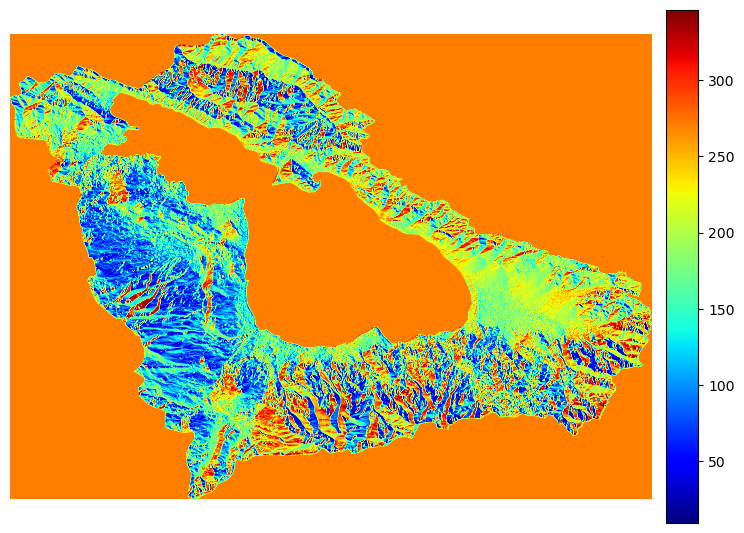

{'vmin': 9.462322235107422, 'vmax': 346.29302978515625}

In [33]:
aspect = rd.TerrainAttribute(beau, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8,5.5))